# SVI with a Normalizing Flow guide

Thanks to their expressiveness, normalizing flows (see [normalizing flow introduction](normalizing_flows_intro.ipynb)) are great guide candidates for stochastic variational inference (SVI). This notebook demonstrates how to perform amortized SVI with a normalizing flow as guide.

> In this notebook we use [Zuko](https://zuko.readthedocs.io/) to implement normalizing flows, but similar results can be obtained with other PyTorch-based flow libraries.

In [1]:
import pyro
import torch
import zuko  # pip install zuko

from corner import corner, overplot_points  # pip install corner
from pyro.contrib.zuko import ZukoToPyro
from pyro.optim import ClippedAdam
from pyro.infer import SVI, Trace_ELBO
from torch import Tensor

## Model

We define a simple non-linear model $p(x | z)$ with a standard Gaussian prior $p(z)$ over the latent variables $z$.

In [2]:
prior = pyro.distributions.Normal(torch.zeros(3), torch.ones(3)).to_event(1)

def likelihood(z: Tensor):
    mu = z[..., :2]
    rho = z[..., 2].tanh() * 0.99

    cov = 1e-2 * torch.stack([
        torch.ones_like(rho), rho,
        rho, torch.ones_like(rho),
    ], dim=-1).unflatten(-1, (2, 2))

    return pyro.distributions.MultivariateNormal(mu, cov)

def model(x: Tensor):
    with pyro.plate("data", x.shape[1]):
        z = pyro.sample("z", prior)

        with pyro.plate("obs", 5):
            pyro.sample("x", likelihood(z), obs=x)

We sample 64 reference latent variables and observations $(z^*, x^*)$. In practice, $z^*$ is unknown, and $x^*$ is your data.

In [3]:
z_star = prior.sample((64,))
x_star = likelihood(z_star).sample((5,))

## Guide

We define the guide $q_\phi(z | x)$ with a normalizing flow. We choose a conditional [neural spline flow](https://arxiv.org/abs/1906.04032) borrowed from the [Zuko](https://zuko.readthedocs.io/) library. Because Zuko distributions are very similar to Pyro distributions, a thin wrapper (`ZukoToPyro`) is sufficient to make Zuko and Pyro 100% compatible.

In [4]:
flow = zuko.flows.NSF(features=3, context=10, transforms=1, hidden_features=(256, 256))
flow.transform = flow.transform.inv  # inverse autoregressive flow (IAF) are fast to sample from

def guide(x: Tensor):
    pyro.module("flow", flow)

    with pyro.plate("data", x.shape[1]):  # amortized
        pyro.sample("z", ZukoToPyro(flow(x.transpose(0, 1).flatten(-2))))

## SVI

We train our guide with a standard stochastic variational inference (SVI) pipeline. We use 16 particles to reduce the variance of the ELBO and clip the norm of the gradients to make training more stable.

In [5]:
pyro.clear_param_store()

svi = SVI(model, guide, optim=ClippedAdam({"lr": 1e-3, "clip_norm": 10.0}), loss=Trace_ELBO(num_particles=16, vectorize_particles=True))

for step in range(4096 + 1):
    elbo = svi.step(x_star)

    if step % 256 == 0:
        print(f'({step})', elbo)

(0) 209195.08367919922
(256) -25.225540161132812
(512) -99.09033203125
(768) -102.66302490234375
(1024) -138.8058319091797
(1280) -92.15625
(1536) -136.78167724609375
(1792) -87.76119995117188
(2048) -116.21714782714844
(2304) -162.0266571044922
(2560) -91.13175964355469
(2816) -164.86270141601562
(3072) -98.17607116699219
(3328) -102.58432006835938
(3584) -151.61912536621094
(3840) -77.94436645507812
(4096) -121.82719421386719


## Posterior predictive

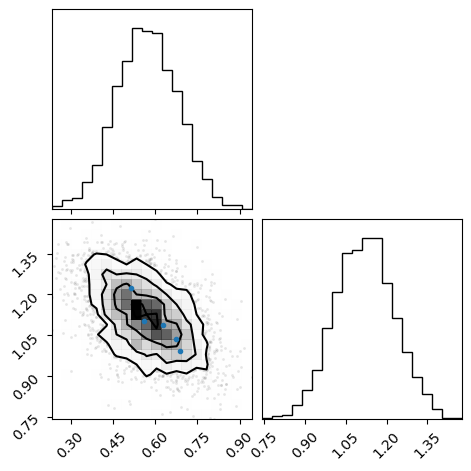

In [6]:
z = flow(x_star[:, 0].flatten()).sample((4096,))
x = likelihood(z).sample()

fig = corner(x.numpy())

overplot_points(fig, x_star[:, 0].numpy())

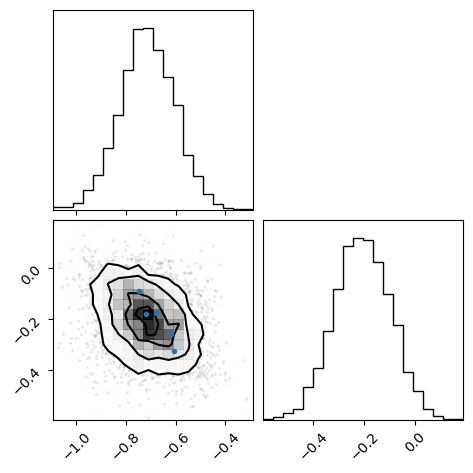

In [7]:
z = flow(x_star[:, 1].flatten()).sample((4096,))
x = likelihood(z).sample()

fig = corner(x.numpy())

overplot_points(fig, x_star[:, 1].numpy())